In [29]:
from fastai.imports import *
from fastai.vision import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed

In [2]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")

In [3]:
train_dir = data_dir / "training"
files = train_dir.ls()
print(len(files))

1044


In [4]:
files[0]

PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_132_GTC.tif')

In [5]:
labels_train = data_dir / "truth-training.txt"
with open(labels_train, "r") as f:
    labels = f.readlines()
labels[4]

'JAX_Tile_005\n'

In [6]:
set([str(f.name).split("_")[-1] for f in files])

{'DSM.tif', 'DTM.tif', 'GTC.tif', 'GTI.tif', 'GTL.tif', 'RGB.tif'}

In [53]:
rgb_files = [f for f in files if str(f.name).endswith('RGB.tif')]
len(rgb_files)

174

In [8]:
ground_truth_class_level_files = [f for f in files if str(f.name).endswith('GTL.tif')]
ground_truth_inst_level_files = [f for f in files if str(f.name).endswith('GTI.tif')]

In [72]:
ground_truth_class_level_files[:5]

[PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_007_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_031_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_032_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_017_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_128_GTL.tif')]

In [71]:
def convert_gtl(fpath, outpath):    
    a = sktif.imread(str(fpath))
    b = a.copy
    
    np.place(b, b==6,1) #building
    np.place(b, b!=6,0) #void
    
    assert b.max()<=1, b.max()
    
    sktif.imsave(str(outpath),b)


In [73]:
inpaths = ground_truth_class_level_files
outpaths = [str(f).replace("GTL", "pytorch_GTL") for f in ground_truth_class_level_files]
outpaths[:5]

['/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_007_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_031_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_032_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_017_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_128_pytorch_GTL.tif']

In [67]:
%time  [convert_gtl(inpath, outpath) for inpath, outpath in zip(inpaths, outpaths)];

CPU times: user 2.04 s, sys: 279 ms, total: 2.32 s
Wall time: 2.32 s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [68]:
len(inpaths)

174

In [69]:
def scale_percentile(matrix):
    # scale tiff files read by tifffile to an rgb format readable by e.g. mpl for display
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

def plot_mask_img(img_id, road_mask_width=4):
    mask_fname = data_dir / "training" / f"{img_id}_pytorch_GTL.tif"
    img_fname = data_dir / "training" / f"{img_id}_RGB.tif"
    img_mask= tiff.imread(str(mask_fname))
    img_rgb= tiff.imread(str(img_fname))
    f = plt.figure(figsize=(10,6))
    plt.subplot(121)
    tiff.imshow(img_rgb, figure=f, subplot=121);
    print(img_rgb.shape)
    plt.subplot(122)
    tiff.imshow(img_mask,figure=f, subplot=122);

In [59]:
img_ids = [f.name.replace("_RGB.tif", "") for f in rgb_files]

(2048, 2048)


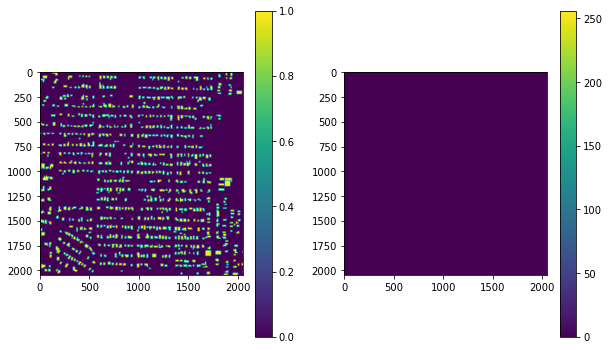

In [70]:
plot_mask_img(img_ids[10])

In [57]:
img_ids[10]

'JAX_Tile_132'

In [27]:
class NRandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

            
        
    def __init__(self, output_size, n=4, padding=0, pad_if_needed=False):
        self.output_size = output_size # size of crop
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.n = n # number of crops
        
    def _get_crop(image, mask, w, h):
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        mask = mask[top: top + new_h,
                      left: left + new_w]
        
        return image, mask


    def __call__(self, image, mask):
        assert image.shape[:2] == mask.shape[:2]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        crops = [self._get_crop(image, mask, w, h) for i in range(self.n)]

        return tuple(crops)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
        return {'image': image, 'landmarks': landmarks}

Object `accimage` not found.


In [ ]:
class Urban3DDataset(Dataset):
    """satellite image dataset"""

    def __init__(self, img_ids, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        mask_fname = data_dir / "training" / f"{self.img_ids[idx]}_GTL.tif"
        img_fname = data_dir / "training" / f"{self.img_ids[idx]}_RGB.tif"
        
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


In [ ]:
class Urban3DDataset(data.Dataset):
    
    
    dataset_types = ['train', 'test']
    
    images_subfolder_name = 'images'
    annotations_subfolder_name = 'annotations'
    
    ignore_label = 255

    
    def __init__(self,
                 dataset_root,
                 dataset_type=0,
                 joint_transform=None):

        # dataset_type:
        # 0 - train
        # 1 - test
        
        # Used for remapping from original labels to training ones
        self.ordered_train_labels = np.asarray( [self.ignore_label] + range(13) )

        self.dataset_root = dataset_root
        self.joint_transform = joint_transform

        dataset_type_name = self.dataset_types[dataset_type]

        images_folder_path = os.path.join(dataset_root, dataset_type_name, self.images_subfolder_name)

        annotations_folder_path = os.path.join(dataset_root, dataset_type_name, self.annotations_subfolder_name)

        images_filenames = sorted(os.listdir(images_folder_path))
        annotations_filenames = sorted(os.listdir(annotations_folder_path))

        self.images_filenames = list(map(lambda x: os.path.join(images_folder_path, x), images_filenames))
        self.annotations_filenames = list(map(lambda x: os.path.join(annotations_folder_path, x), annotations_filenames))
            
    def __len__(self):

        return len(self.images_filenames)
    
    
    def __getitem__(self, index):

        img_path = self.images_filenames[index]
        annotation_path = self.annotations_filenames[index]

        _img = Image.open(img_path).convert('RGB')
        
        # TODO: maybe can be done in a better way
        _target = Image.open(annotation_path)
        
        _target_np = np.asarray(_target).copy()
        
        # https://stackoverflow.com/questions/8188726/how-do-i-do-this-array-lookup-replace-with-numpy
        _target_np = self.ordered_train_labels[_target_np].astype(np.uint8)
        
        _target = Image.fromarray(_target_np)

        if self.joint_transform is not None:

            _img, _target = self.joint_transform([_img, _target])

        return _img, _target

In [26]:
# from torchvision.transforms import functional as F



class NRandomCrop(object):

    def __init__(self, size, n=1, padding=0, pad_if_needed=False):
        self.size = size # size of crop
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.n = n # number of crops

    @staticmethod
    def get_params(img, output_size, n):
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i_list = [random.randint(0, h - th) for i in range(n)]
        j_list = [random.randint(0, w - tw) for i in range(n)]
        return i_list, j_list, th, tw
    
    def _is_np_arr(self, img):
        if isinstance(np.ndarray, img):
            img = PIL.Image.fromarray(img)

    def __call__(self, img):
        if isinstance(np.ndarray, img):
            img = torch.from_numpy(img)
        if self.padding > 0:
            img = F.pad(img, self.padding)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, (int((1 + self.size[1] - img.size[0]) / 2), 0))
        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, (0, int((1 + self.size[0] - img.size[1]) / 2)))

        i, j, h, w = self.get_params(img, self.size, self.n)

        return n_random_crops(img, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)


def n_random_crops(img, x, y, h, w):

    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    crops = []
    for i in range(len(x)):
        new_crop = img.crop((y[i], x[i], y[i] + w, x[i] + h))
        crops.append(new_crop)
    return tuple(crops)

mean, sd = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = transforms.Compose(
    [NRandomCrop(size=32, n=5, padding=4),
     transforms.Lambda(
         lambda crops: torch.stack([transforms.Normalize(mean, sd)(transforms.ToTensor()(crop)) for crop in crops])),
     ]
)


train_data = datasets.CIFAR10(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=4)
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images.squeeze(0)))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(0)))


In [ ]:
def get_mask_fn(img_id):
    return  data_dir / "training" / f"{img_id}_GTL.tif"

codes = np.array(["void", "road"])
src = (SegmentationItemList.from_folder(rgb_256)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_mask_fn, classes=codes)
      )

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import utils
import numpy as np


class LossBinary:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss


class LossMulti:
    def __init__(self, jaccard_weight=0, class_weights=None, num_classes=1):
        if class_weights is not None:
            nll_weight = utils.cuda(
                torch.from_numpy(class_weights.astype(np.float32)))
        else:
            nll_weight = None
        seldef get_mask_fn(fname):
    return mask_256 / fname.name.replace("rgb", "mask").replace("tif", "png")
codes = np.array(["void", "road"])
src = (SegmentationItemList.from_folder(rgb_256)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_mask_fn, classes=codes)
      )f.nll_loss = nn.NLLLoss2d(weight=nll_weight)
        self.jaccard_weight = jaccard_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            for cls in range(self.num_classes):
                jaccard_target = (targets == cls).float()
                jaccard_output = outputs[:, cls].exp()
                intersection = (jaccard_output * jaccard_target).sum()

                union = jaccard_output.sum() + jaccard_target.sum()
                loss -= torch.log((intersection + eps) / (union - intersection + eps)) * self.jaccard_weight
        return loss

In [17]:
2048/256

8.0